<a href="https://colab.research.google.com/github/jurados/NotesPytorch/blob/main/%5B03%5D_PyTorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

# Split data into training and test sets
from sklearn.model_selection import train_test_split

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print(f'PyTorch version: {torch.__version__}')

Device: cpu
PyTorch version: 2.3.1+cu121


In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise= 0.03,
                    random_state=42)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1":X[:,0],
                        "X2": X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


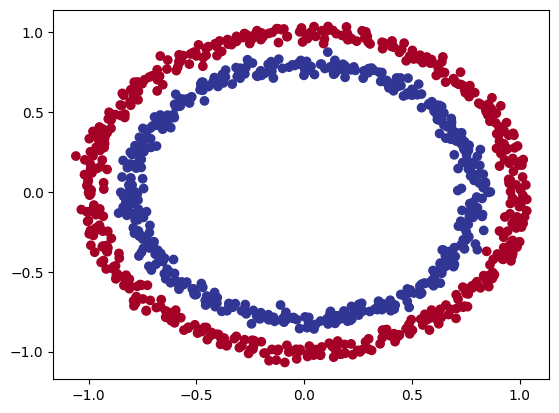

In [6]:
# Visualize
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Check Input and Output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


Turn data into tensors and create train and test splits

In [13]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`).
3. Define a loss function and optimizer.
4. Create a training and test loop.

In [18]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layers_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscale in 5 features
    self.layers_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs

    #self.two_linear_layers = nn.Sequential(
    #    nn.Linear(in_features=2, out_features=5),
    #    nn.Linear(in_features=5, out_features=1)
    #).to(device)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1) # x -> layer_1 -> layer_2 -> output
    # return two_linear_layers(x)

# 4. instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layers_1): Linear(in_features=2, out_features=5, bias=True)
  (layers_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
next(model_0.parameters()).device

device(type='cpu')

In [20]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6253,  0.4133],
                      [-0.3740,  0.0523],
                      [ 0.1126, -0.1285],
                      [ 0.4142, -0.0007],
                      [-0.0701, -0.4534]])),
             ('0.bias', tensor([-0.1092, -0.1560,  0.3192, -0.5294, -0.1367])),
             ('1.weight',
              tensor([[ 0.0796, -0.1528, -0.2933, -0.4020,  0.3088]])),
             ('1.bias', tensor([-0.3210]))])

In [22]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shpape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shpape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shpape: torch.Size([200, 1])
Length of test samples: 200, Shpape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.2387],
        [-0.3047],
        [-0.1243],
        [-0.2708],
        [-0.2175],
        [-0.2571],
        [-0.3691],
        [-0.3582],
        [-0.1205],
        [-0.3101]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Step loss function and optimizer

For example for regession you might want MAE or MSE (Mean Absolute Error or Mean Squeared Error)

For classification oyout might want binary cross entropy or categorical cross entropy.

And for optimizers, two of the most common and useful are SGD and Adam.

In [23]:
# Setup the loss function
#loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = torch.nn.BCEWithLogitsLoss() # BCEWithLogistLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [24]:
# Calcualte accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100

  return acc

## Training model

### Going from raw logits -> prediction probabilities -> prediction labels

We cant convert these **logits** into **prediction probabilities** by passing them to some kind of activation function.

Then we can convert our model's prediction probabilities to **predcition labels** by either rounding them or taking the `argmax()`

In [25]:
# View the first 5 ouputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2387],
        [-0.3047],
        [-0.1243],
        [-0.2708],
        [-0.2175]])

In [26]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilitiess
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4406],
        [0.4244],
        [0.4690],
        [0.4327],
        [0.4458]])

For our prediction probabilities vaulues, we need to perfom a range-style rounding on them:

- `y_pred_probs` >= 0.5, y=1 (class 1)
- `y_pred_probs` < 0.5,  y=0 (class 0)

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -< pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

Building a training and testing loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.eval()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -< pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #               y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expect raw logits as input
                 y_train )
  acc  = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward

  # 5. optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred  = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  # Print out what's happening'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc {acc: .2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 10 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 20 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 30 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 40 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 50 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 60 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 70 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 80 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%
Epoch: 90 | Loss: 0.70122, Acc  50.00% | Test loss: 0.69819, Test acc: 50.00%


## Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything ...

So to inspect it let's make somre predictions and make them visual.

In [29]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print('helper_functions.py already exists, skypping downloading')
else:
  print('Download helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py",'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


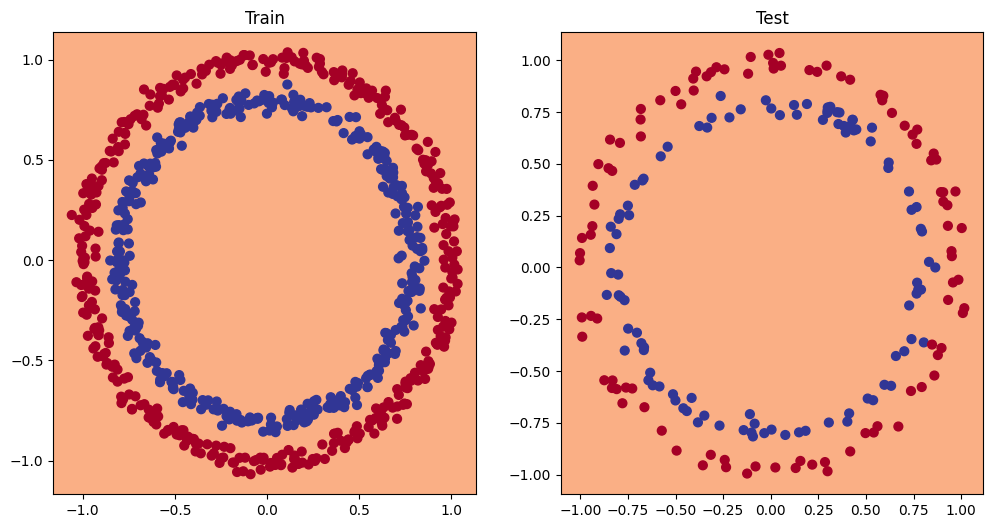

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model_0, X = X_train, y = y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model_0, X = X_test, y = y_test)

## Improving a model (from a model perpective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden untis
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

The ooptions are all from a model's perpective because they deal directly with the model, rather than the data.

And because these option are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

In [31]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features = 1)

  def forward(self,x):
    z = self.layer_1(x)
    z = self.layer_1(z)
    z = self.layer_1(z)
    return z

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.3)

In [33]:
# Write a training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -< pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc  = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward

  # 5. optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred  = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  # Print out what's happening'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc {acc: .2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (800x10 and 2x10)

Preparing data to see if our model can fit a straight line

In [34]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [35]:
# Create train and test splits
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

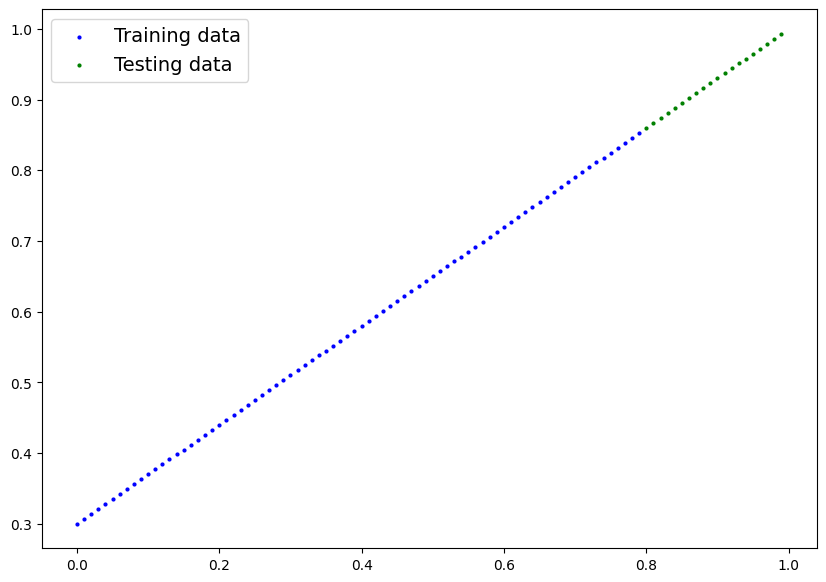

In [36]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

Adjusting `model_1` to fit a straight line

In [37]:
# Same architecture as model_1 (but usign nn.Squential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [39]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)

  # Print out what's happening'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test loss: 0.02127
Epoch: 800 | Loss: 0.05600 | Test loss: 0.01425
Epoch: 900 | Loss: 0.05571 | Test loss: 0.00603


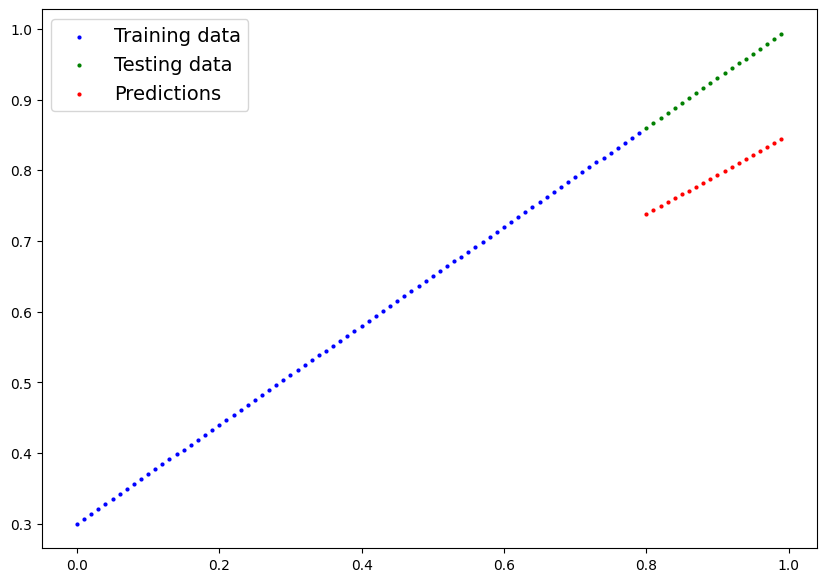

In [40]:
# Turn on evaluation mode
model_2.eval()

# make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## The missing piece: non-linearity

### Recreating non-linear data (red and blue circles)

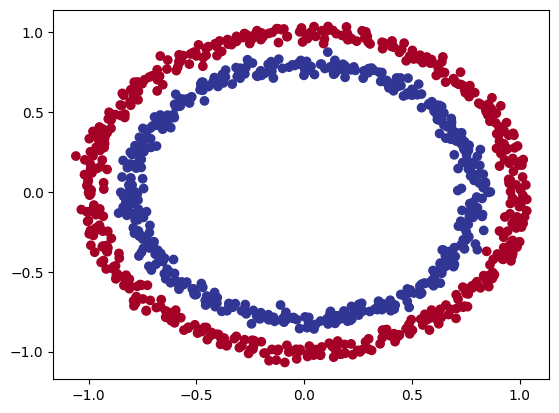

In [43]:
n_samples = 1000

X,y = make_circles(n_samples, noise = 0.03 , random_state = 42)

plt.scatter(X[:,0] ,X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [44]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Building a model with non-linearity

* Linear = straight linear
* Non-linear = non-straight lines

Artificial neural networks are a large combinations of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [45]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self,x):
    # Where should we pot our non-linear actation functions?
    z = self.layer_1(x)
    z = self.relu(z)
    z = self.layer_2(z)
    z = self.relu(z)
    z = self.layer_3(z)

    return z

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr = 0.3)

Training a model with non-linearity

In [47]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
epochs = 1000
for epoch in range(epochs):
  ## Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -< pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc  = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred  = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)

  # Print out what's happening'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc {acc: .2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc  50.00% | Test loss: 0.69306, Test acc: 50.00%
Epoch: 100 | Loss: 0.68796, Acc  53.00% | Test loss: 0.68720, Test acc: 56.00%
Epoch: 200 | Loss: 0.67525, Acc  54.37% | Test loss: 0.67280, Test acc: 56.50%
Epoch: 300 | Loss: 0.62461, Acc  73.75% | Test loss: 0.62162, Test acc: 78.50%
Epoch: 400 | Loss: 0.37448, Acc  97.38% | Test loss: 0.40781, Test acc: 92.50%
Epoch: 500 | Loss: 0.36910, Acc  76.75% | Test loss: 0.45300, Test acc: 73.50%
Epoch: 600 | Loss: 0.08191, Acc  100.00% | Test loss: 0.11981, Test acc: 97.50%
Epoch: 700 | Loss: 0.04117, Acc  100.00% | Test loss: 0.06974, Test acc: 99.00%
Epoch: 800 | Loss: 0.02686, Acc  100.00% | Test loss: 0.04934, Test acc: 99.00%
Epoch: 900 | Loss: 0.01987, Acc  100.00% | Test loss: 0.04013, Test acc: 99.00%


Evaluating a model trained with non-linear activation functions

In [48]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

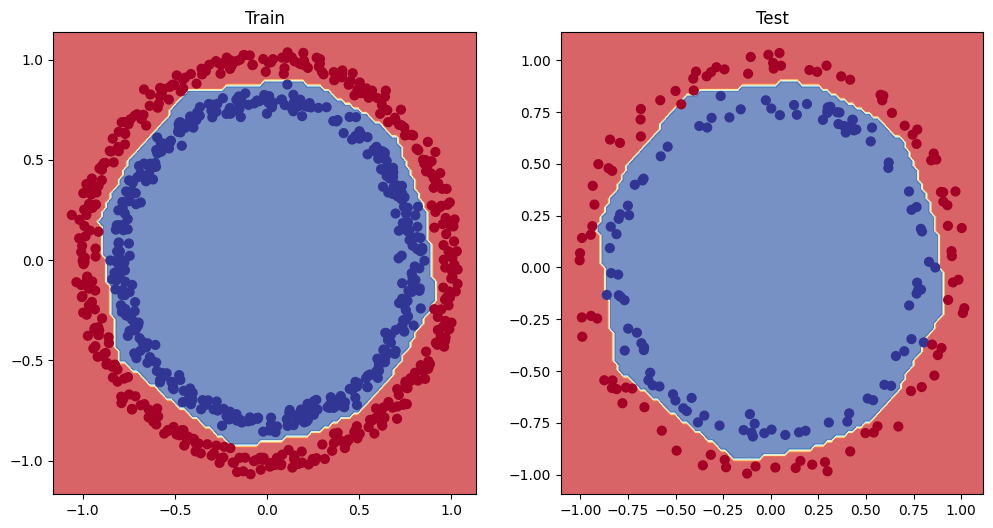

In [49]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model_3, X = X_train, y = y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model_3, X = X_test, y = y_test)

## Pulling it all together with a multi-class classifcation problem
- Binary classification: one thing or another.
- Multi-class classifcation: more than one thing or another.

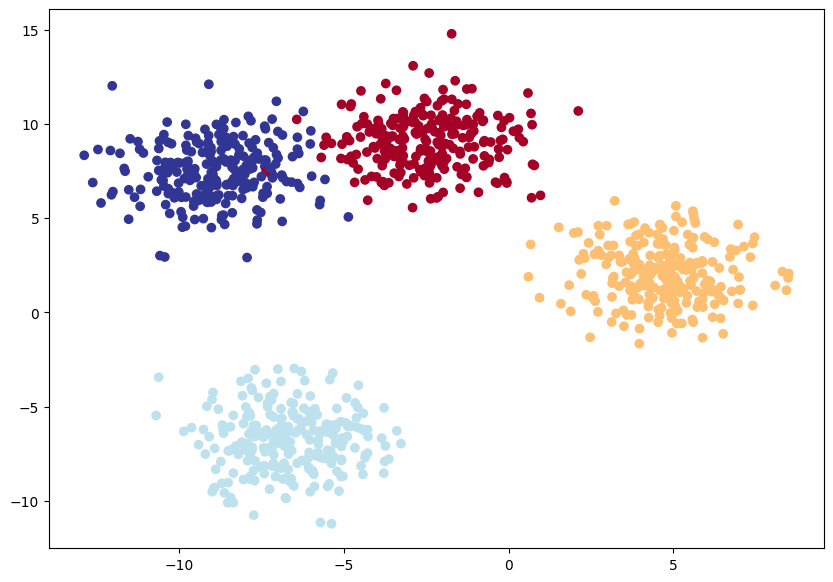

In [54]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob , y_blob = make_blobs(n_samples=1000,
                             n_features = NUM_FEATURES,
                             centers = NUM_CLASSES,
                             cluster_std=1.5,
                             random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blobs = torch.from_numpy(X_blob).type(torch.float)
y_blobs = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,
                                                                        test_size=0.2,
                                                                        random_state = RANDOM_SEED)
X_blob_train = torch.from_numpy(X_blob_train).type(torch.float)
y_blob_train = torch.from_numpy(y_blob_train).type(torch.LongTensor)
X_blob_test = torch.from_numpy(X_blob_test).type(torch.float)
y_blob_test = torch.from_numpy(y_blob_test).type(torch.LongTensor)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

Building a multi-class classification model in PyTorch

In [55]:
# Setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch import nn
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initialized multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between lates, default 8

    Return:

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

Create a loss fuunction and an optimizer for a multi-class classification model

In [56]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(), lr= 0.01)

Getting prediction probabilities for a multi-class PyTorch model

In [60]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.type(torch.float32))

y_logits[:10]

tensor([[ 0.8161, -0.8846, -0.2847,  0.4252],
        [-0.9359, -2.0669,  0.9583, -2.2816],
        [-0.6742, -0.0694,  0.8067, -1.3123],
        [ 0.6858, -0.5307, -0.1840,  0.3610],
        [ 0.1430, -1.9414,  0.1816, -0.8017],
        [-1.1805, -2.3145,  1.1303, -2.6851],
        [-0.4175,  0.1534,  0.6255, -0.9003],
        [-0.1357, -1.9379,  0.3829, -1.1728],
        [-1.0798, -0.3154,  1.0950, -1.9303],
        [-0.0296, -1.9148,  0.3067, -1.0240]])

In [61]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(torch.sum(y_pred_probs[0]))
print(torch.argmax(y_pred_probs[0]))

tensor(1.)
tensor(0)


In [62]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 0])

Creating a training loop and testing loop for a multi-class with PyTorch

In [63]:
 # Fit the multi-class model to the data
 # Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100

  return acc

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Build training and evaluation loop
epochs = 1000
for epoch in range(epochs):
  ## Training
  model_4.train()

  y_logits = model_4(X_blob_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> pred probs -< pred labels

  loss = loss_fn(y_logits,y_blob_train)
  acc  = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    test_pred  = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,y_pred = test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc {acc: .2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.92116, Acc  26.00% | Test loss: 1.63789, Test acc: 38.00%
Epoch: 100 | Loss: 0.26105, Acc  98.62% | Test loss: 0.25118, Test acc: 98.00%
Epoch: 200 | Loss: 0.11334, Acc  99.00% | Test loss: 0.10797, Test acc: 98.50%
Epoch: 300 | Loss: 0.07522, Acc  99.00% | Test loss: 0.06919, Test acc: 98.50%
Epoch: 400 | Loss: 0.05927, Acc  99.00% | Test loss: 0.05268, Test acc: 98.50%
Epoch: 500 | Loss: 0.05077, Acc  99.00% | Test loss: 0.04377, Test acc: 99.50%
Epoch: 600 | Loss: 0.04556, Acc  99.00% | Test loss: 0.03825, Test acc: 99.50%
Epoch: 700 | Loss: 0.04208, Acc  99.00% | Test loss: 0.03451, Test acc: 99.50%
Epoch: 800 | Loss: 0.03962, Acc  99.00% | Test loss: 0.03181, Test acc: 99.50%
Epoch: 900 | Loss: 0.03778, Acc  99.00% | Test loss: 0.02977, Test acc: 99.50%


In [64]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[  9.1827,  15.1916,  -8.7170,  -3.8210],
        [ -0.9545, -18.7857,  -2.5882,   4.6597],
        [-14.1140, -24.4888,  13.7234,   5.4541],
        [  4.8685,  10.0497,  -4.0814,  -2.6902],
        [ 10.1435,   5.7040, -12.0628,  -1.2447],
        [ -1.7049, -23.0406,  -2.5130,   5.7503],
        [-13.0288, -19.8048,  13.2951,   4.2678],
        [  6.9875,  -0.8340,  -9.2757,   0.3210],
        [-16.6842, -32.5184,  15.4045,   7.4487],
        [  7.9922,   1.5106, -10.1057,  -0.2475]])

In [65]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4507e-03, 9.9755e-01, 4.1261e-11, 5.5187e-09],
        [3.6297e-03, 6.5448e-11, 7.0858e-04, 9.9566e-01],
        [8.1331e-13, 2.5384e-17, 9.9974e-01, 2.5620e-04],
        [5.5900e-03, 9.9441e-01, 7.2529e-07, 2.9153e-06],
        [9.8833e-01, 1.1664e-02, 2.2430e-10, 1.1196e-05],
        [5.7797e-04, 3.1327e-13, 2.5759e-04, 9.9916e-01],
        [3.6949e-12, 4.2155e-15, 9.9988e-01, 1.2008e-04],
        [9.9833e-01, 4.0034e-04, 8.6350e-08, 1.2707e-03],
        [1.1585e-14, 1.5387e-21, 9.9965e-01, 3.5051e-04],
        [9.9821e-01, 1.5286e-03, 1.3785e-08, 2.6349e-04]])

In [66]:
# Go from pred probs -> pred labels
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

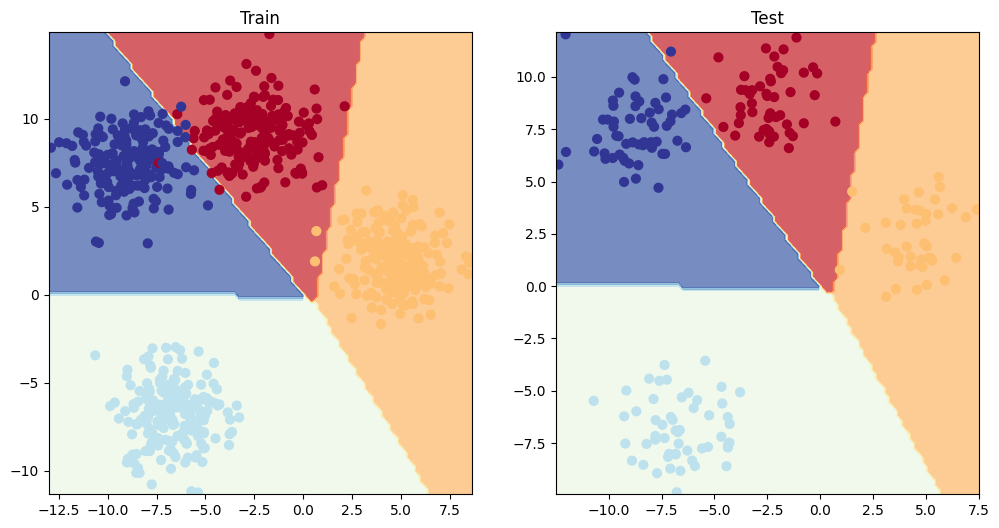

In [67]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model_4, X = X_blob_train, y = y_blob_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model_4, X = X_blob_test, y = y_blob_test)